In [1]:
import os
import cv2
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import BatchNormalization
import numpy as np

In [2]:
data_path='./sky/data'
gt_path='./sky/groundtruth'

In [3]:
X = []
Y = []
for file in os.scandir(data_path):
    gt_im_path=os.path.join(gt_path, file.name.split('.')[0]+"_gt.pgm")
    #print(file.path,gt_im_path)
    im = cv2.imread(file.path)
    im = cv2.resize(im,(248,248))/255
    gt = cv2.imread(gt_im_path,-1) # -1 is used ecause of 'pgm' format
    gt = cv2.resize(gt,(248,248))/255
    X.append(im)
    Y.append(gt)
    
X = np.array(X).reshape((-1,248,248,3)) #
Y = np.array(Y).reshape((-1,248,248,1))

print(X.shape)
print(Y.shape)

(60, 248, 248, 3)
(60, 248, 248, 1)


In [5]:
batch_size = 8
epochs = 150
inChannel = 3
x, y = 248, 248
input_img = Input(shape = (x, y, inChannel))
conv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

#decoder
conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2) # 14 x 14 x 64
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv6) # 28 x 28 x 1

In [6]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 248, 248, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 248, 248, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 62, 32)       

In [ ]:
autoencoder_train = autoencoder.fit(X, Y, batch_size=batch_size,epochs=epochs,verbose=1)

Epoch 1/150
8/8 [==============================] - 65s 8s/step - loss: 0.2756
Epoch 2/150
8/8 [==============================] - 54s 7s/step - loss: 0.2325
Epoch 3/150
8/8 [==============================] - 54s 7s/step - loss: 0.3209
Epoch 4/150
8/8 [==============================] - 56s 7s/step - loss: 0.1578
Epoch 5/150
8/8 [==============================] - 54s 7s/step - loss: 0.1275
Epoch 6/150
8/8 [==============================] - 54s 7s/step - loss: 0.1011
Epoch 7/150
8/8 [==============================] - 53s 7s/step - loss: 0.1443
Epoch 8/150
8/8 [==============================] - 53s 7s/step - loss: 0.0964
Epoch 9/150
8/8 [==============================] - 56s 7s/step - loss: 0.1002
Epoch 10/150
8/8 [==============================] - 58s 7s/step - loss: 0.1281
Epoch 11/150
8/8 [==============================] - 60s 7s/step - loss: 0.1414
Epoch 12/150
8/8 [==============================] - 56s 7s/step - loss: 0.1327
Epoch 13/150
8/8 [==============================] - 57s 7s/st

In [ ]:
from matplotlib import pyplot as plt
image=autoencoder.predict(X[:3])
for i in range(3):
    plt.figure(figsize=[5, 5])
    curr_img = np.reshape(image[i], (248,248))
    plt.imshow(curr_img,cmap='gray')
    plt.show()

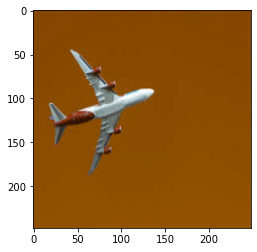

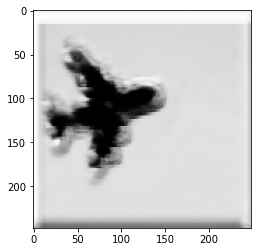

In [164]:
im = cv2.imread('images.jpg')
img = cv2.resize(im,(248,248))/255
img=img.reshape((-1,248,248,3))
plt.imshow(img[0])
plt.show()
out=autoencoder.predict(img)
plt.imshow(out[0], cmap='gray')
plt.show()



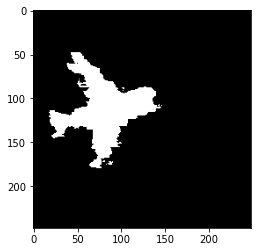

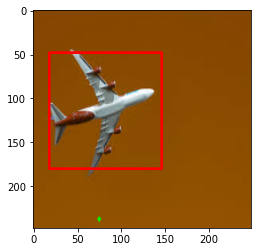

In [183]:
final = np.ceil(out[0]*255).astype('uint8')
ret,final = cv2.threshold(final,90,255,cv2.THRESH_BINARY_INV)
plt.imshow(final, cmap='gray')
plt.show()
contours, hierarchy = cv2.findContours(final,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
final_out = cv2.resize(im,(248,248))
boundingBoxes = [cv2.boundingRect(c) for c in contours]
(cnts, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes),key=lambda b:b[1][i]))
cv2.rectangle(final_out,((boundingBoxes[-1][0]),(boundingBoxes[-1][1])),((boundingBoxes[-1][0]+boundingBoxes[-1][2]) ,(boundingBoxes[-1][1]+boundingBoxes[-1][3])),(255,0,0), 2)
plt.imshow(final_out)
plt.show()

In [191]:
from matplotlib import pyplot as plt

for i in range(3):
    plt.figure(figsize=[5, 5])
    plt.imshow(gt[i].ravel().reshape(248,248),cmap='gray')
    plt.show()

ValueError: cannot reshape array of size 248 into shape (248,248)

<Figure size 360x360 with 0 Axes>